In [1]:
cd ..

/home/anindya/workspace/Text2SQL/newlib/text2sql


## Evaluator

premsql evaluators helps you to evaluate your text-to-sql models on various your validation datasets. Currently we support two metrics for evaluation:

1. Execution Accuracy
2. Valid Efficiency Score

**Execution Accuracy (EX):** From the name, it is clear that the correctness of the LLM is measured by comparing the executed results from the LLM with the ground truth.
    
**Valid Efficiency Score (VES):** The primary objective of LLM-generated SQL queries is to be accurate. However, it also needs to be performance-optimized when dealing with big data. This metric asses both of the objectives. It quantifies how efficient the query is and whether the query is accurate or not. The figure below shows how it is been computed. 

Now let's jump in to the code to see how we can use premsql to evaluate models or pipelines using these metrics. 

To startoff, we import all the necessary things required to evaluate our models. 

In [2]:
import json
from pathlib import Path 
from premsql.evaluator import Text2SQLEvaluator, SQLiteExecutor

Our evaluation methods are agnostic to models or any pipelines. To evaluate we rely on a special response JSON structure. So ideally we assume that, before doing evaluation, you have got all the model responses saved inside a JSON. 

In our [premsql.generators](/examples/generators.ipynb) section, we have show you how you can get the model responses for validation or inference purposes. We start off by defining our experiment_path. You can get the experiment path manually or you can also get it from your generator object (more on that below). 

In [3]:
experiment_path = Path(
    "experiments/test/testing_finetuned_deepseek_full_fewshot/"
)
responses = json.load(open(experiment_path / "predict.json", "r"))

Since text-to-SQL is a database dependent task, so it requires a DB source to execute the SQL generated from the model and compare it with the result executed from the ground truth SQL. 

So evaluator depends on an executor object. An executor derives from `premsql.evaluator.base.BaseExecutor` abstract class. This class has one method called `execute_sql`. We are going to use `SQLiteExecutor` to execute in SQLite DBs. You can also make your own executor to evaluate with your custom executor. More on that below. 

In [4]:
executor = SQLiteExecutor()
evaluator = Text2SQLEvaluator(
    executor=executor, experiment_path=experiment_path
)

Now our setup is done, let's compute the execution accuracy score using premsql evaluator. 

In [5]:
ex = evaluator.execute(
    metric_name="accuracy", 
    model_responses=responses, 
    filter_by="difficulty"
)

  0%|          | 0/1534 [00:00<?, ?it/s]

2024-09-05 13:50:28,471 - [UTILS] - INFO - Saved JSON in: experiments/test/testing_finetuned_deepseek_full_fewshot/accuracy.json
2024-09-05 13:50:28,522 - [UTILS] - INFO - Saved JSON in: experiments/test/testing_finetuned_deepseek_full_fewshot/predict.json


This will start the evaluation. Since the responses are coming from premsql.generators. So the responses not only has model responses but all the input data (dict) that was given it the generator before generating results. So this means you can similarly filter the responses using any kind of filter similar how you did it for [datasets](/exampels/datasets.ipynb). Let's print the results to see the scores. 

In [8]:
print(f" Execution Accuracy is: {ex}")

Execution Accuracy is: {'simple': 49.18918918918919, 'challenging': 24.137931034482758, 'moderate': 
38.146551724137936, 'overall': 43.481095176010434}

Once you get the result, you will also see that the results are saved in the same `experiment_path` which was initially given to the object. This saves lot of informations like the errors for each of the validation questions and other infos too. This would help us to understand the problems and debug them. Here is an instance of how it looks like:

```json

{
    "question_id": 23,
    "db_id": "california_schools",
    "question": "List the names of schools with more than 30 difference in enrollements between K-12 and ages 5-17? Please also give the full street adress of the schools.",
    "evidence": "Diffrence in enrollement = `Enrollment (K-12)` - `Enrollment (Ages 5-17)`",
    "SQL": "SELECT T1.School, T1.Street FROM schools AS T1 INNER JOIN frpm AS T2 ON T1.CDSCode = T2.CDSCode WHERE T2.`Enrollment (K-12)` - T2.`Enrollment (Ages 5-17)` > 30",
    "difficulty": "moderate",
    "db_path": "data/bird/validation/dev_databases/california_schools/california_schools.sqlite",
    "prompt": "<\uff5cbegin\u2581of\u2581sentence\uff5c>You are an ... Additional Knowledge: Diffrence in enrollement = `Enrollment (K-12)` - `Enrollment (Ages 5-17)`# Question: List the names of schools with more than 30 difference in enrollements between K-12 and ages 5-17? Please also give the full street adress of the schools.\n\n# SQL:\n",
    "dataset_type": "real",
    "generated": "SELECT T2.`School Name`, T2.Street, T2.City, T2.Zip FROM satscores AS T1 INNER JOIN frpm AS T2 ON T1.cds = T2.CDSCode WHERE T1.`Enrollment (K-12)` - T1.`Enrollment (Ages 5-17)` > 30",
    "error": "no such column: T2.Street",
    "accuracy": 0
},
```

All of the informations are saved in the provided `experiment_path`. Similarly, you can calculate Valid Efficiency Score (ves) using the same method. Now for this one, let's filter the result based on `db_id`.

In [7]:
ves = evaluator.execute(
    metric_name="ves", 
    model_responses=responses, 
    filter_by="db_id"
)

  0%|          | 0/1534 [00:00<?, ?it/s]

2024-09-05 14:03:40,245 - [UTILS] - INFO - Saved JSON in: experiments/test/testing_finetuned_deepseek_full_fewshot/ves.json
2024-09-05 14:03:40,296 - [UTILS] - INFO - Saved JSON in: experiments/test/testing_finetuned_deepseek_full_fewshot/predict.json


In [9]:
print(ves)

{
    'card_games': 43.07853075375516,
    'formula_1': 31.775724213967827,
    'superhero': 71.8911921365164,
    'thrombosis_prediction': 32.04531820456654,
    'european_football_2': 55.13455641323744,
    'debit_card_specializing': 31.443812836674972,
    'financial': 20.009163037705697,
    'toxicology': 38.062478162792736,
    'california_schools': 20.28612811030907,
    'codebase_community': 61.334184528675365,
    'student_club': 55.627231251046005,
    'overall': 43.69090268345865
}

Let's now plot the result to see what is the distribution of result based on different databases. These kind of filters lets us to analyse the results of the model or pipeline on several key aspects which helps us to understand where the next iterations can be done on. 

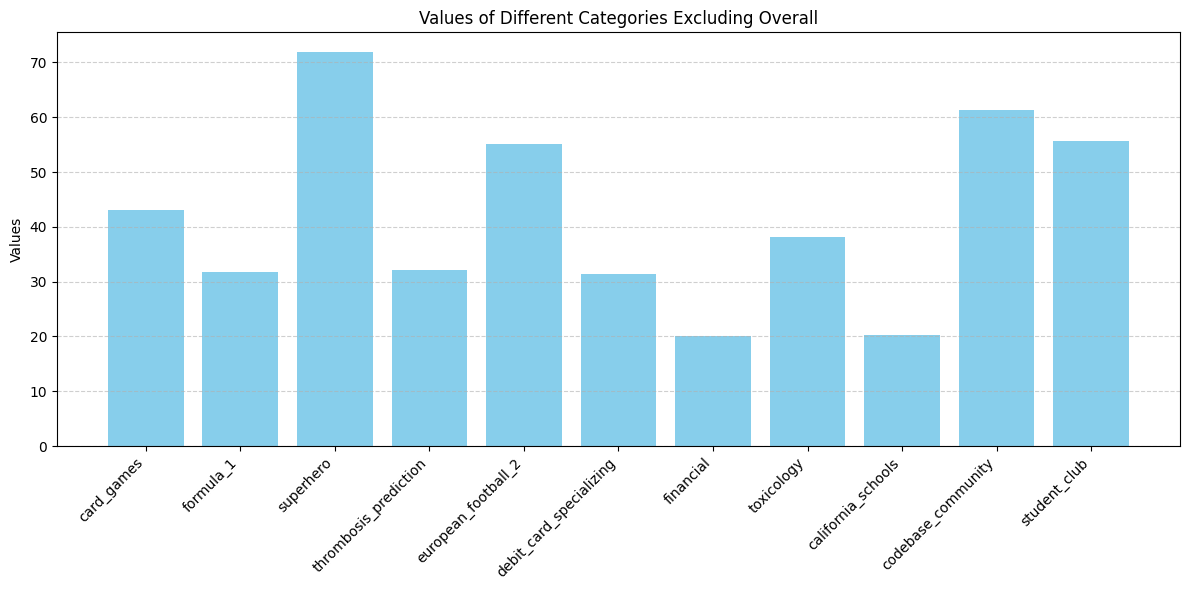

In [13]:
ves.pop("overall")

plt.figure(figsize=(12, 6))
plt.bar(ves.keys(), ves.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Values')
plt.title('Values of Different Categories Excluding Overall')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Writing your executor

As mentioned earlier, premsql.evaluators can be used as a plug and play tool for evaluating models and pipelines on any kind of databases. Here is an example how to write your custom executor for postgresql.

Simply you need to inherit the BaseExecutor class and define the `execute_sql` function. You can also change some additional functions but those are out of scope of this example. 

In [ ]:
import psycopg2
import time
from premsql.evaluator.base import BaseExecutor

class PostgreSQLExecutor(BaseExecutor):
    def execute_sql(self, sql: str, dsn_or_db_path: str) -> dict:
        conn = psycopg2.connect(dsn_or_db_path)
        cursor = conn.cursor()

        start_time = time.time()
        try:
            cursor.execute(sql)
            result = cursor.fetchall()
            error = None
        except Exception as e:
            result = None
            error = str(e)

        end_time = time.time()
        cursor.close()
        conn.close()

        result = {
            "result": result,
            "error": error,
            "execution_time": end_time - start_time,
        }
        return result

That's it, it is that easy to do customizations. You can extend it to any kind of connectors as long as it outputs the dict shown above. 

### Future Improvements:

Currently evaluations are not parallizable. So in our next iterations, we are going to do those optimizations and additionally we are also going to introduce some more metrics (example: F1 score) to  visualize more such metrics. 